In [1]:
#build-ins
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from sklearn import linear_model
from tqdm import tqdm

#custom modules
import sys
sys.path.append("./matching_modules")
import PSM

In [2]:
import warnings
warnings.filterwarnings("ignore")
%reload_ext autoreload
%autoreload 2

In [3]:
matching_data = "../../matching_data/data_DIAB.p"
data = pd.read_pickle(matching_data)

A = data.loc[:,["AGE_AT_MIDMONTH", "MBR_GNDR", "ALLOW_AMT"]]
B = data.loc[:,"CC_ADHD":"CC_VISUAL_IMPAIR"]
X = A.merge(B, how='left', left_index=True, right_index=True)
T = data.TREATED
Y = data.OUTCOME
data = pd.concat([X,Y,T], axis=1)

In [4]:
data.head()

AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  \
0               81         0          0        0             0   
1               82         0        101        0             0   
2               78         1      13007        0             0   
3               77         0          0        0             0   
4               76         1        898        0             0   

   CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  \
0                  0       0          0                    1             0   
1                  0       0          0                    1             0   
2                  0       0          0                    0             1   
3                  0       0          0                    0             0   
4                  0       0          0                    0             1   

   ...  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  \
0  ...                 0                       0               0   
1  ...                 0                       0               0   
2  ...                 0                       0               0   
3  ...                 0                       0               0   
4  ...                 0                       0               0   

   CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  \
0                0          0           0                   0   
1                0          0           0                   0   
2                0          0           0                   0   
3                0          0           0                   0   
4                0          0           0                   0   

   CC_VISUAL_IMPAIR  OUTCOME  TREATED  
0                 0      0.0        1  
1                 0      0.0        1  
2                 0      0.0        1  
3                 0      0.0        1  
4                 0      0.0        1  

[5 rows x 74 columns]

## Generate Matches

In [5]:
#initialize by generating and saving the propensity score
PSM = PSM.PropensityScoreMatching(data)

In [6]:
#get matched indices
PSM.getControlsForTreated(data.copy())
PSM.getTreatedForControls(data.copy())

print(PSM.matchedControlIndices.shape)
print(PSM.matchedTreatedIndices.shape)

(978, 1)
(6116956, 1)


## Plot Matched Populations

In [7]:
controls = data.loc[data.TREATED==0]

In [8]:
matched_controls = controls.iloc[np.squeeze(PSM.matchedControlIndices)]

In [9]:
treated = data.loc[data.TREATED==1]

In [10]:
matched_population = pd.concat([treated, matched_controls], axis=0)

(0, 5000)

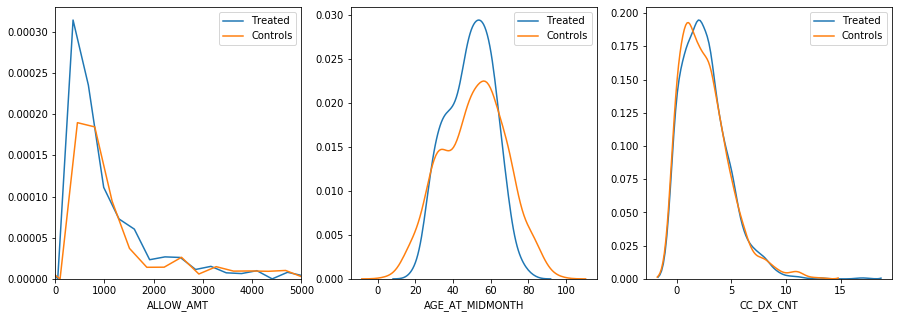

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = sns.distplot(treated.ALLOW_AMT, hist=False, label='Treated', ax=axes[0])
ax1 = sns.distplot(matched_controls.ALLOW_AMT, hist=False, label='Controls', ax=axes[0])
ax2 = sns.distplot(treated.AGE_AT_MIDMONTH, hist=False, label='Treated', ax=axes[1])
ax2 = sns.distplot(matched_controls.AGE_AT_MIDMONTH, hist=False, label='Controls', ax=axes[1])
ax3 = sns.distplot(treated.CC_DX_CNT, hist=False, label='Treated', ax=axes[2])
ax3 = sns.distplot(matched_controls.CC_DX_CNT, hist=False, label='Controls', ax=axes[2])

ax1.set_xlim(0,5000)

## Statistical T Tests
If threshold is set to 0.10, then 14 variables out of 72. If threshold is set to 0.05, then 10 features. 

In [18]:
def log_(x):
    return np.log(x) if x>0 else 0
treated.ALLOW_AMT = treated.ALLOW_AMT.apply(log_)
matched_controls.ALLOW_AMT = matched_controls.ALLOW_AMT.apply(log_)

In [19]:
from scipy import stats
cols_len = len(treated.columns.to_list()[:-3])
statistics = pd.DataFrame(columns=["Feature", "T_Stat", "P_Val"])
for i in range(cols_len):
    stat = stats.ttest_ind(treated.iloc[:,i], matched_controls.iloc[:,i], equal_var=False)
    statistics.loc[i] = np.array([treated.columns.to_list()[i],stat[0], stat[1]])
statistics[['T_Stat', 'P_Val']] = statistics[['T_Stat', 'P_Val']].astype(float)

In [20]:
thresh = 0.05
statistics.sort_values(by=['P_Val'], ascending=True).query("P_Val<=@thresh")

Feature    T_Stat     P_Val
25           CC_DIABETES -4.909873  0.000001
53           CC_MIGRAINE  3.200043  0.001397
0        AGE_AT_MIDMONTH -3.141302  0.001709
5      CC_ALZHEIMER_PLUS -2.507230  0.012287
22         CC_DEPRESSION  2.433561  0.015041
61           CC_PRESSURE -2.340799  0.019403
8    CC_ANXIETY_DISORDER  2.285615  0.022384
4           CC_ALZHEIMER -2.240659  0.025272
12             CC_AUTISM -2.127043  0.033612
42      CC_HEPATITIS_GEN -2.127043  0.033612
19  CC_COLORECTAL_CANCER -2.003078  0.045445

## Calculate Effects

In [ ]:
#calculate effects in different unit/groups
PSM.calculateAndSaveITE(data)
PSM.calculateATT(data.copy())
PSM.calculateATC(data.copy())
PSM.calculateATE(data.copy())

In [ ]:
data.head()